In [1]:
import ccxt
import pandas as pd
import numpy as np

# Initialize the Binance exchange object
exchange = ccxt.binance()

# Define the symbol (Bitcoin/USDT)
symbol = 'BTC/USDT'

# Define the number of days of historical data you want
num_days = 3000

# Fetch hourly OHLCV (Open, High, Low, Close, Volume) data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', limit=num_days)

# Create a DataFrame from the raw data
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Convert the timestamp to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set the timestamp as the DataFrame index
df.set_index('timestamp', inplace=True)

# Calculate daily volatility by hours
import math
log_returns = np.log(df['close']).diff()
hourly_volatility = log_returns.groupby([df.index.weekday]).std() * math.sqrt(365) * 100

# Display the hourly volatility
print(hourly_volatility)
# log_returns

timestamp
0    75.319041
1    56.855261
2    65.323621
3    57.239433
4    68.731139
5    31.921079
6    43.429584
Name: close, dtype: float64


In [2]:
target = (log_returns.abs() * math.sqrt(365) * 100)
feature_columns = []
df = target.to_frame('target')
df.loc[df.index.values[-1] + pd.Timedelta('1D')] = np.nan
target = df['target']

old_columns = set(df.columns)
df['lag_1'] = df['target'].shift(0)
df['lag_2'] = df['target'].shift(1)
df['lag_7'] = df['target'].shift(6)
df['lag_14'] = df['target'].shift(13)
df['lag_21'] = df['target'].shift(20)
df['lag_28'] = df['target'].shift(27)

df['ma_7'] = df['target'].rolling(7).mean()
df['ma_14'] = df['target'].rolling(14).mean()
df['ma_21'] = df['target'].rolling(21).mean()

df['vol_7'] = df['target'].rolling(7).apply(lambda x: np.sqrt(x.mean()))
df['vol_14'] = df['target'].rolling(14).mean(lambda x: np.sqrt(x.mean()))
df['vol_21'] = df['target'].rolling(21).mean(lambda x: np.sqrt(x.mean()))

df['min_7'] = df['target'].rolling(7).min()
df['min_14'] = df['target'].rolling(14).min()
df['min_21'] = df['target'].rolling(21).min()

df['max_7'] = df['target'].rolling(7).max()
df['max_14'] = df['target'].rolling(14).max()
df['max_21'] = df['target'].rolling(21).max()

df['std_7'] = df['target'].rolling(7).std()
df['std_14'] = df['target'].rolling(14).std()
df['std_21'] = df['target'].rolling(21).std()
df['std_42'] = df['target'].rolling(42).std()

df['ewm_1'] = df['target'].ewm(alpha=.9).mean()
df['ewm_3'] = df['target'].ewm(alpha=.7).mean()
df['ewm_7'] = df['target'].ewm(span=7).mean()
df['ewm_14'] = df['target'].ewm(span=14).mean()
df['ewm_21'] = df['target'].ewm(span=21).mean()

numeric_columns = list(set(df.columns) - old_columns)
feature_columns += list(set(df.columns) - old_columns)


# old_columns = set(df.columns)
# done = []
# for numeric_column in numeric_columns:
#     for numeric_column2 in numeric_columns:
#         if numeric_columns != numeric_column2 and numeric_column2+numeric_column not in done:
#             done.append(numeric_column+numeric_column2)
#             df[numeric_column + '_' + numeric_column2] = df[numeric_column] - df[numeric_column2]
# feature_columns += list(set(df.columns) - old_columns)

# date features
df['dayofweek'] = df.index.dayofweek
df['dayofmonth'] = df.index.month
df['year'] = df.index.year
feature_columns += ['dayofweek', 'dayofmonth']

for feature in feature_columns:
    df[feature] = df[feature].shift(1)

    
features = df[feature_columns]
# features = df[temp_list]
target = target.iloc[50:]
features = features.iloc[50:]

In [3]:
# df[feature_columns + ['target']].iloc[-20:].plot()
features

,lag_1,lag_21,min_14,ewm_1,ewm_21,vol_21,min_7,std_14,lag_28,std_21,...,vol_14,std_7,vol_7,ma_14,ma_21,max_21,ewm_14,ewm_3,dayofweek,dayofmonth
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-25,35.122706,33.722326,5.260810,38.848090,50.491301,44.527782,8.499239,37.587565,137.916079,33.303307,...,45.350419,46.299859,7.615850,45.350419,44.527782,145.306997,50.408560,44.740649,5.0,7.0
2021-07-26,61.616055,88.447476,5.260810,59.339259,51.511332,45.856055,8.499239,37.823696,11.345083,33.406889,...,46.705973,42.377545,8.035817,46.705973,45.856055,145.306997,51.904061,56.553434,6.0,7.0
2021-07-27,97.709492,29.813975,5.260810,93.872468,55.743942,46.297103,8.499239,39.939751,76.902840,34.052217,...,48.933578,43.944675,8.387345,48.933578,46.297103,145.306997,58.015588,85.362674,0.0,7.0
2021-07-28,110.645529,20.086157,5.260810,108.968223,60.770382,50.146225,8.499239,42.219193,46.675423,36.571140,...,55.356985,46.385994,8.758207,55.356985,50.146225,145.306997,65.037032,103.060673,1.0,7.0
2021-07-29,27.004525,56.479838,8.273254,35.200894,57.680987,50.475671,8.499239,40.603569,85.872118,36.317088,...,56.910107,38.023666,7.733424,56.910107,50.475671,145.306997,59.963452,49.821369,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,5.941764,5.636640,3.126448,8.321162,23.071176,26.806973,5.941764,21.703304,56.944512,22.676697,...,23.018842,7.660087,4.209454,23.018842,26.806973,78.903956,21.127801,12.425333,6.0,2.0
2024-02-27,98.874373,17.377861,3.126448,89.819052,29.962375,31.246865,5.941764,28.001089,16.020627,27.033510,...,25.586759,31.289049,5.471550,25.586759,31.246865,98.874373,31.494010,72.939661,0.0,2.0
2024-02-28,87.763042,54.649880,3.126448,87.968643,35.216982,34.598541,5.941764,31.998915,16.133672,29.480531,...,31.259152,37.350380,6.319449,31.259152,34.598541,98.874373,38.996548,83.316028,1.0,2.0


In [8]:
import lightgbm as lgb

CUT_OFF = '2024-2-1'
idx_train = features.index <= pd.to_datetime(CUT_OFF)
idx_test = features.index > pd.to_datetime(CUT_OFF)

In [9]:
target[idx_test]

timestamp
2024-02-02      5.183944
2024-02-03      8.372766
2024-02-04     19.115853
2024-02-05      5.636640
2024-02-06     17.377861
2024-02-07     54.649880
2024-02-08     40.030191
2024-02-09     76.251890
2024-02-10     24.900240
2024-02-11     21.835952
2024-02-12     62.923531
2024-02-13      8.349545
2024-02-14     78.903956
2024-02-15      3.126448
2024-02-16      8.968345
2024-02-17     17.729258
2024-02-18     18.226206
2024-02-19     13.345832
2024-02-20     17.780020
2024-02-21     15.027037
2024-02-22     20.782723
2024-02-23     20.382437
2024-02-24     30.776681
2024-02-25      5.941764
2024-02-26     98.874373
2024-02-27     87.763042
2024-02-28    172.658186
2024-02-29     35.701916
2024-03-01           NaN
Name: target, dtype: float64

In [10]:
train_data = lgb.Dataset(features[idx_train], label=target[idx_train])
val_data = lgb.Dataset(features[idx_test], label=target[idx_test], reference=train_data)

import warnings
warnings.simplefilter('ignore')

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'mape',
    'num_leaves': 31,
    'n_estimators': 1000,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
early_stopping_rounds = 100
bst = lgb.train(params, train_data, valid_sets=[val_data], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)

# Predict on validation set
val_pred = bst.predict(features[idx_test], num_iteration=bst.best_iteration)
val_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

array([37.61319136, 29.3982739 , 33.3724671 , 39.6423879 , 39.61199385,
       40.22728635, 37.6620203 , 47.82781669, 32.68949241, 34.04661026,
       30.77913129, 39.259333  , 33.83495843, 35.87807946, 35.85550809,
       30.7198869 , 31.88722212, 36.84468266, 36.11834966, 38.91709856,
       33.04846894, 35.79005083, 33.39056645, 35.89323447, 33.90298554,
       45.33434078, 40.53321639, 37.39341584, 39.3700197 ])

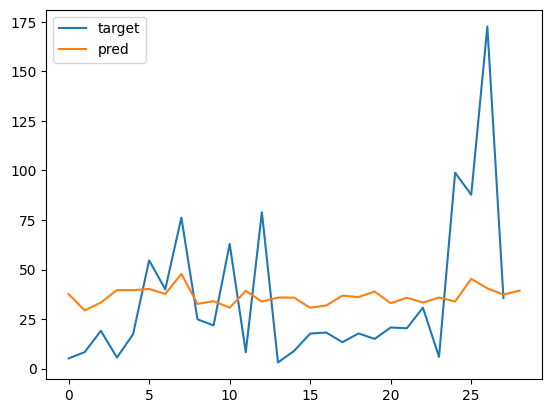

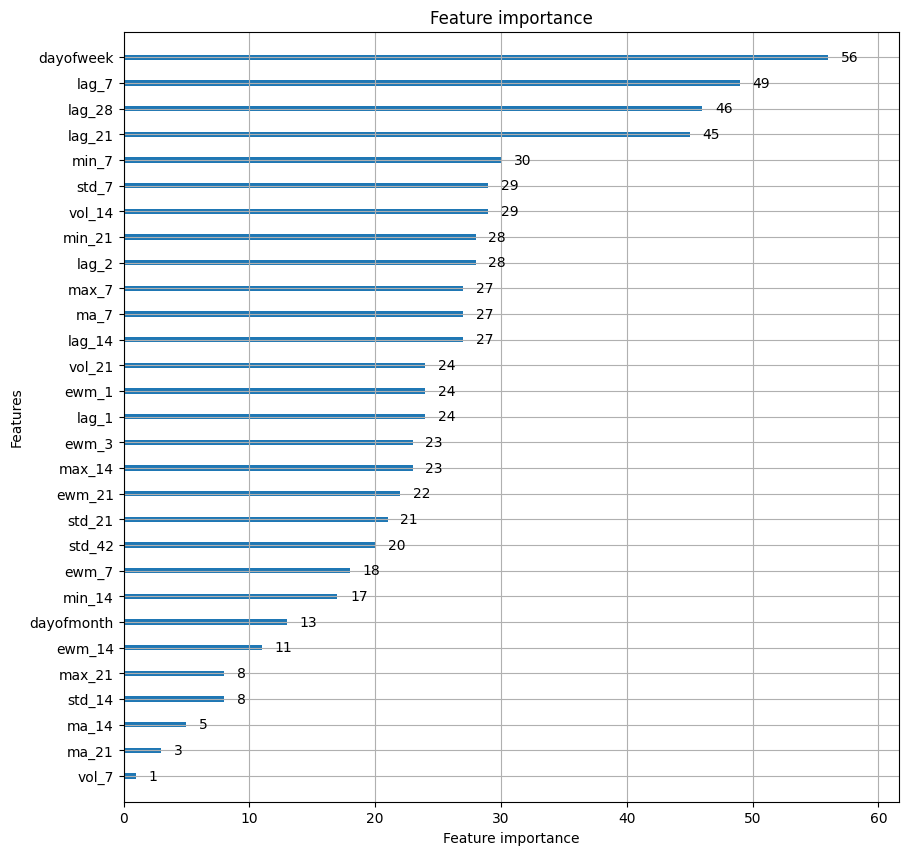

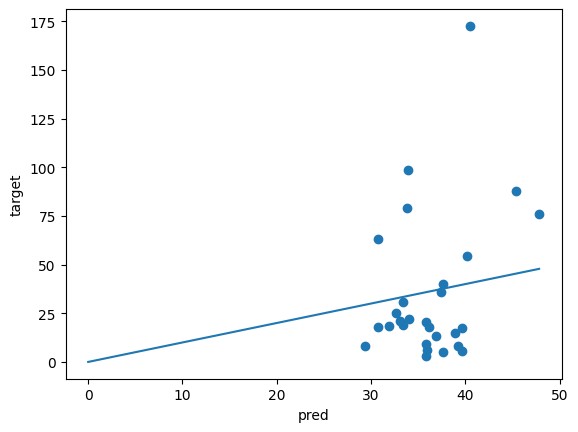

In [11]:

import matplotlib.pyplot as plt
plt.plot(target[idx_test].values, label = 'target')
plt.plot(val_pred, label = 'pred')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,10))
lgb.plot_importance(bst, ax=ax)

plt.show()

plt.scatter(val_pred, target[idx_test].values)
plt.xlabel('pred')
plt.ylabel('target')
plt.plot([0, max(val_pred)], [0, max(val_pred)])
plt.show()

In [12]:
# np.nanmean(np.log(target[idx_test].values) - np.log(val_pred))
temp_list = list(features.columns.values[np.argsort(bst.feature_importance())[-50:]])
temp_list

['vol_7',
 'ma_21',
 'ma_14',
 'max_21',
 'std_14',
 'ewm_14',
 'dayofmonth',
 'min_14',
 'ewm_7',
 'std_42',
 'std_21',
 'ewm_21',
 'max_14',
 'ewm_3',
 'ewm_1',
 'vol_21',
 'lag_1',
 'max_7',
 'lag_14',
 'ma_7',
 'min_21',
 'lag_2',
 'std_7',
 'vol_14',
 'min_7',
 'lag_21',
 'lag_28',
 'lag_7',
 'dayofweek']

In [13]:
target[idx_test], val_pred

(timestamp
 2024-02-02      5.183944
 2024-02-03      8.372766
 2024-02-04     19.115853
 2024-02-05      5.636640
 2024-02-06     17.377861
 2024-02-07     54.649880
 2024-02-08     40.030191
 2024-02-09     76.251890
 2024-02-10     24.900240
 2024-02-11     21.835952
 2024-02-12     62.923531
 2024-02-13      8.349545
 2024-02-14     78.903956
 2024-02-15      3.126448
 2024-02-16      8.968345
 2024-02-17     17.729258
 2024-02-18     18.226206
 2024-02-19     13.345832
 2024-02-20     17.780020
 2024-02-21     15.027037
 2024-02-22     20.782723
 2024-02-23     20.382437
 2024-02-24     30.776681
 2024-02-25      5.941764
 2024-02-26     98.874373
 2024-02-27     87.763042
 2024-02-28    172.658186
 2024-02-29     35.701916
 2024-03-01           NaN
 Name: target, dtype: float64,
 array([37.61319136, 29.3982739 , 33.3724671 , 39.6423879 , 39.61199385,
        40.22728635, 37.6620203 , 47.82781669, 32.68949241, 34.04661026,
        30.77913129, 39.259333  , 33.83495843, 35.87807946